In [18]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import graphviz

In [2]:
df = pd.read_csv('../master_data.csv')
df.head(3)

C:\Users\moyersjm\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,4,5,12,13,14,15,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,video_id,title,channel_id,channel_title,published_at,view_count,likes,dislikes,comment_count,...,description,comments,publishedAt,channelId,channelTitle,categoryId,trending_date,thumbnail_link,comments_disabled,ratings_disabled
0,0,--0bCF-iK2E,Jadon Sancho Magical Skills & Goals,UC6UL29enLNe4mqwTfAyeNuw,Bundesliga,2021-07-01 10:00:00,1048888,19515,226,1319,...,Enjoy the best skills and goals from Jadon San...,"Respect to Dortmund fans,must be sad losing hi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,--14w5SOEUs,Migos - Avalanche (Official Video),UCGIelM2Dj3zza3xyV3pL3WQ,MigosVEVO,2021-06-10 16:00:00,15352638,359277,7479,18729,...,"Watch the the official video for Migos - ""Aval...",Migos just makes me want to live my live to th...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,UClBKH8yZRcM4AsRjDVEdjMg,Television Academy,2021-09-20 01:03:32,925281,11212,401,831,...,Hannah Waddingham wins the Emmy for Supporting...,Hannah's energy bursts through any screen. Wel...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.channel_id.fillna(df.channelId,inplace=True)
df.channel_title.fillna(df.channelTitle,inplace=True)
df.published_at.fillna(df.publishedAt,inplace=True)

In [16]:
features = df.drop(['Unnamed: 0','video_id',
                    #'title',
                    'channel_id',
                    #'tags',
                    #'description',
                    #'comments',
                    'publishedAt',
                    'channelId', 'channelTitle',
                    'categoryId','trending_date',
                   'thumbnail_link','comments_disabled',
                   'ratings_disabled'], axis=1)
features = features.dropna()
#target = features.dislikes
#features = features.drop('dislikes',axis=1)
features.head(3)

,title,channel_title,published_at,view_count,likes,dislikes,comment_count,tags,description,comments
0,Jadon Sancho Magical Skills & Goals,Bundesliga,2021-07-01 10:00:00,1048888,19515,226,1319,football soccer ftbol alemn Bundesliga season ...,Enjoy the best skills and goals from Jadon San...,"Respect to Dortmund fans,must be sad losing hi..."
1,Migos - Avalanche (Official Video),MigosVEVO,2021-06-10 16:00:00,15352638,359277,7479,18729,Migos Avalanche Quality Control Music/Motown R...,"Watch the the official video for Migos - ""Aval...",Migos just makes me want to live my live to th...
2,Supporting Actress in a Comedy: 73rd Emmys,Television Academy,2021-09-20 01:03:32,925281,11212,401,831,,Hannah Waddingham wins the Emmy for Supporting...,Hannah's energy bursts through any screen. Wel...


In [17]:
# target = features.dislikes / features.likes
target = features.dislikes / features.view_count

In [19]:
corpus = pd.DataFrame()
corpus['dislike_to_view'] = target
corpus['dislike_to_view_bins'] = pd.qcut(target,q=7,labels=['very-low','low','mid-low','mid','mid-high','high','very-high'])
corpus['comments'] = features.comments
corpus['description'] = features.description
corpus['tags'] = features.tags
Vectorizer = TfidfVectorizer(analyzer='word',stop_words='english')

In [24]:
tfidf = Vectorizer.fit_transform(corpus.tags)

In [25]:
parameters = {'alpha':[.001,.001,.01,.1,1,10,100,1000,10000]}
NBayes = MultinomialNB()
NBayesCV = GridSearchCV(NBayes,
                       param_grid=parameters,
                       return_train_score=True,
                       n_jobs=4)

In [26]:
NBayesCV.fit(tfidf, corpus.dislike_to_view_bins)

GridSearchCV(estimator=MultinomialNB(), n_jobs=4,
             param_grid={'alpha': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             return_train_score=True)

In [27]:
NBayesCV.best_params_

{'alpha': 0.1}

In [28]:
NBayesCV.best_score_

0.3196384154082348

In [34]:
1/7

0.14285714285714285

Using tags as a predictor is only twice as effective versus baseline

In [35]:
tfidf = Vectorizer.fit_transform(corpus.description)
NBayes = MultinomialNB()
NBayesCV = GridSearchCV(NBayes,
                       param_grid=parameters,
                       return_train_score=True,
                       n_jobs=4)
NBayesCV.fit(tfidf, corpus.dislike_to_view_bins)

GridSearchCV(estimator=MultinomialNB(), n_jobs=4,
             param_grid={'alpha': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             return_train_score=True)

In [36]:
NBayesCV.best_score_

0.3558127947123138

Description isn't much better

In [37]:
tfidf = Vectorizer.fit_transform(corpus.comments)
NBayes = MultinomialNB()
NBayesCV = GridSearchCV(NBayes,
                       param_grid=parameters,
                       return_train_score=True,
                       n_jobs=4)
NBayesCV.fit(tfidf, corpus.dislike_to_view_bins)

GridSearchCV(estimator=MultinomialNB(), n_jobs=4,
             param_grid={'alpha': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             return_train_score=True)

In [38]:
NBayesCV.best_score_

0.30383222065289595

Using comments is even worse. Let's try 2-grams

In [42]:
Vectorizer = Vectorizer = TfidfVectorizer(analyzer='word',stop_words='english',ngram_range=(1,2))

In [49]:
tfidf = Vectorizer.fit_transform(corpus.tags)
NBayes = MultinomialNB()
NBayesCV = GridSearchCV(NBayes,
                       param_grid=parameters,
                       return_train_score=True,
                       n_jobs=4)
NBayesCV.fit(tfidf, corpus.dislike_to_view_bins)

GridSearchCV(estimator=MultinomialNB(), n_jobs=4,
             param_grid={'alpha': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             return_train_score=True)

In [50]:
NBayesCV.best_score_
#This was the best for 2-grams

0.33235842807807797

Well that was disappointing. Maybe the title will help us?

In [47]:
tfidf = Vectorizer.fit_transform(features.title)
NBayes = MultinomialNB()
NBayesCV = GridSearchCV(NBayes,
                       param_grid=parameters,
                       return_train_score=True,
                       n_jobs=4)
NBayesCV.fit(tfidf, corpus.dislike_to_view_bins)

GridSearchCV(estimator=MultinomialNB(), n_jobs=4,
             param_grid={'alpha': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             return_train_score=True)

In [48]:
NBayesCV.best_score_

0.3127416080113856

Nope. Darn, guess this is a dead end.

In [51]:
Vectorizer = TfidfVectorizer(analyzer='word',stop_words='english')
tfidf = Vectorizer.fit_transform(features.title + corpus.description + corpus.comments + corpus.tags)
NBayes = MultinomialNB()
NBayesCV = GridSearchCV(NBayes,
                       param_grid=parameters,
                       return_train_score=True,
                       n_jobs=4)
NBayesCV.fit(tfidf, corpus.dislike_to_view_bins)

GridSearchCV(estimator=MultinomialNB(), n_jobs=4,
             param_grid={'alpha': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             return_train_score=True)

In [52]:
NBayesCV.best_score_

0.35312920712147167

If that didn't work, I doubt anything on this front will. Maybe we can try a tree?

In [53]:
#Vectorizer = TfidfVectorizer(analyzer='word',stop_words='english')
#tfidf = Vectorizer.fit_transform(features.title + corpus.description + corpus.comments + corpus.tags)
Tree = tree.DecisionTreeClassifier()
tree_parameters = {'max_depth':range(1,11)}
TreeCV = GridSearchCV(Tree,
                       param_grid=tree_parameters,
                       return_train_score=True,
                       n_jobs=4)
TreeCV.fit(tfidf, corpus.dislike_to_view_bins)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'max_depth': range(1, 11)}, return_train_score=True)

In [54]:
TreeCV.best_score_

0.22579425808064407

In [55]:
TreeCV.best_params_

{'max_depth': 10}

Let's try increasing the depth?

In [56]:
Tree = tree.DecisionTreeClassifier()
tree_parameters = {'max_depth':[10,50,100,200]}
TreeCV = GridSearchCV(Tree,
                       param_grid=tree_parameters,
                       return_train_score=True,
                       n_jobs=6)
TreeCV.fit(tfidf, corpus.dislike_to_view_bins)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=6,
             param_grid={'max_depth': [10, 50, 100, 200]},
             return_train_score=True)

In [57]:
TreeCV.best_score_

0.25010712326499956

In [58]:
TreeCV.best_params_

{'max_depth': 50}

In [67]:
GraphTree = tree.DecisionTreeClassifier(max_depth=5)
GraphTree.fit(tfidf, corpus.dislike_to_view_bins)

DecisionTreeClassifier(max_depth=5)

In [68]:
dot_data = tree.export_graphviz(GraphTree,
                                out_file=None,
                               feature_names=Vectorizer.get_feature_names(),
                               class_names=GraphTree.classes_,
                               proportion=True, # Gives how many in each classification
                               impurity=False, # GINI index
                               filled=True, # Color based on classification
                               rounded=True)

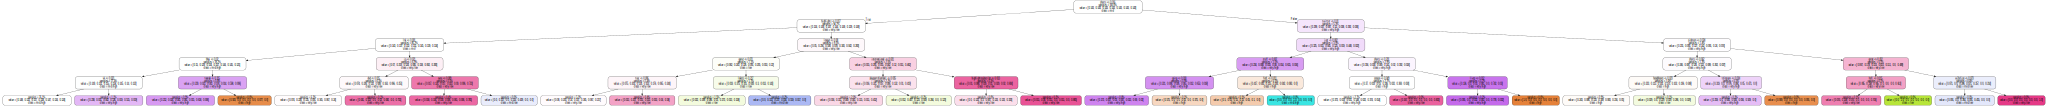

In [69]:
graph = graphviz.Source(dot_data)
graph